In [1]:
############ Performing Naive Bayes on Amazon Fine Food Reviews 


# Data source - URL https://www.kaggle.com/snap/amazon-fine-food-reviews

## Data Contains reviews of fine food from Amazon. 
## It includes information about product, user, ratings, text review. 



In [2]:
## Objective: 
    # 1. Apply Naive Bayes Using Bernoulli NB on Amazon FFR using BOW, Word2Vec, TFIDF, AvgWord2Vec
    # 2. Multinomial NB on Different Featurization
    # 3. Implement using KD-Tree and Brute KNN
    # 4. Metrics: Accuracy, precision, recall, f1-score etc. Confusion matrix

## Predict the Polarity of a given review

In [3]:
## Columns 
    # 1.Id
    # 2.ProductId - unique identifier for the product
    # 3.UserId - unqiue identifier for the user
    # 4.ProfileName
    # 5.HelpfulnessNumerator - number of users who found the review helpful
    # 6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    # 7.Score - rating between 1 and 5
    # 8.Time - timestamp for the review
    # 9.Summary - brief summary of the review
    # 10.Text - text of the review

In [4]:
#######################################################################

# Lets start with imports 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
## Load from SQL file (sqlite)

con = sql.connect('final.sqlite') ## This file obtained after text preprocessing in previous chapter 

df = pd.read_sql_query(''' SELECT * from Reviews''', con)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [6]:
print (df.shape)
print (df['Score'].size)
df.describe()

(364171, 13)
364171


,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [7]:
## EDA and Text PRocessing 

# convert back Polarity back to 0 or 1

def polarity(x):
    if x == 'Positive':
        return 1
    return 0

df['Score'] = df['Score'].map(polarity)

df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b''
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b''
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b''
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b''
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b''


In [8]:
## Consider Whole data .. As Naiye Bayes is faster 

n_samples = 364170
df_sample = df

df_sample.sort_values('Time', inplace=True)
df_sample.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b''
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,b''
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...,b''
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...,b''
298791,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,b''


In [9]:
#### Lets Save data to file and load from file 

import pickle 

def savetofile(obj, filename):
    ''' Save to Local Disk'''
    
    pickle.dump(obj, open(filename+".p","wb"))

def openfromfile(filename):
    ''' Read data from pickled file'''
    
    temp = pickle.load(open(filename+".p","rb"))
    return temp


## Save to Local Machine 
savetofile(df_sample, "sample_nb")

df_sample = openfromfile('sample_nb')

In [13]:
df_sample.shape

(364171, 13)

In [15]:
################### BOW - Bag of Words 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


## Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample['Score'].values,
                                                    test_size=0.3,
                                                   shuffle=False)

uni_gram = CountVectorizer() ## by Default it is uni_gram 

X_train = uni_gram.fit_transform(X_train)
X_train = preprocessing.normalize(X_train) ## normalizing train data 

X_test = uni_gram.transform(X_test)
X_test = preprocessing.normalize(X_test)

print (X_train.shape)
print (X_test.shape)

(254919, 161941)
(109252, 161941)


In [21]:
### Time Series Split 
from sklearn.model_selection import TimeSeriesSplit

## TimeSeriesSplit Example URL: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

ts_cv = TimeSeriesSplit(n_splits=10)
for train, cv in ts_cv.split(X_train):
    print ("Train = ", train)
    print ("CV = ", cv)
    print ("Shape = ", X_train[train].shape, X_train[cv].shape, "\n\n")

Train =  [    0     1     2 ... 23176 23177 23178]
CV =  [23179 23180 23181 ... 46350 46351 46352]
Shape =  (23179, 161941) (23174, 161941) 


Train =  [    0     1     2 ... 46350 46351 46352]
CV =  [46353 46354 46355 ... 69524 69525 69526]
Shape =  (46353, 161941) (23174, 161941) 


Train =  [    0     1     2 ... 69524 69525 69526]
CV =  [69527 69528 69529 ... 92698 92699 92700]
Shape =  (69527, 161941) (23174, 161941) 


Train =  [    0     1     2 ... 92698 92699 92700]
CV =  [ 92701  92702  92703 ... 115872 115873 115874]
Shape =  (92701, 161941) (23174, 161941) 


Train =  [     0      1      2 ... 115872 115873 115874]
CV =  [115875 115876 115877 ... 139046 139047 139048]
Shape =  (115875, 161941) (23174, 161941) 


Train =  [     0      1      2 ... 139046 139047 139048]
CV =  [139049 139050 139051 ... 162220 162221 162222]
Shape =  (139049, 161941) (23174, 161941) 


Train =  [     0      1      2 ... 162220 162221 162222]
CV =  [162223 162224 162225 ... 185394 185395 185396]

In [24]:
%%time
####### ###################################

## Lets Start building our model .. 
# figure out best alpha using TimeSeriesSplit (Forward Chaining Cross Validation)

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

bNB = BernoulliNB()
param_grid = {'alpha':[100, 50, 10, 5, 1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.05, 0.005]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(bNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "NB_gsv_uni")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.5min finished


Best Param =  {'alpha': 0.001}
Best Accuracy =  87.4480020712868
Wall time: 1min 28s


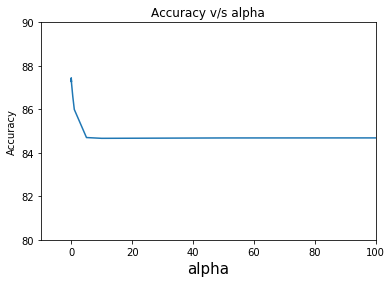

In [25]:
## Lets plot above parms 

x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-10,100)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  88.07893677003624
Precision  0.9185409410973321
Recall  0.9388314093394102
F1-Score  0.9285753457712261


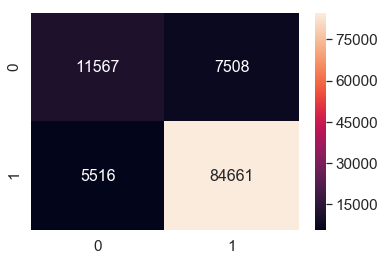

In [29]:
## Accuracy 

bNB = BernoulliNB(gsv.best_params_['alpha']) ## alpha =  0.001
bNB.fit(X_train, y_train)

y_pred = bNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [30]:
%%time
### Multinomial NB 

from sklearn.naive_bayes import MultinomialNB

mNB = MultinomialNB()

param_grid = {'alpha':[100, 50, 10, 5, 1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.05, 0.005]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "NB_gsv_uni_MultiNB")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Param =  {'alpha': 0.001}
Best Accuracy =  86.98929835160094
Wall time: 58.1 s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   57.8s finished


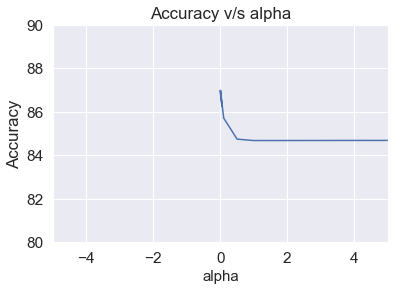

In [34]:
## Lets plot above parms 

x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-5,5)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  85.64145278804965
Precision  0.8540803133437275
Recall  0.9962518158732271
F1-Score  0.9197041435262202


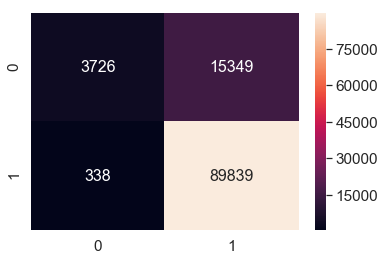

In [35]:
## Accuracy - Multinomial NB

## Accuracy 

mNB = MultinomialNB(gsv.best_params_['alpha']) ## alpha =  0.001
mNB.fit(X_train, y_train)

y_pred = mNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [41]:
###### Feature Importance 

## Notes: 
    # sort features in descending order. High probability means more chance of occurance and hence 
    # coef_ gives therobabilities of the features

## source: https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def get_important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_features =zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    
    for (coef_1, fn_1), (coef_2, fn_2) in top_features:
        print (coef_1, " :: ", fn_1, " \t::\t\t ", coef_2, " :: ", fn_2)

get_important_features(uni_gram, bNB)

			Positive						Negative
-19.194873215584956  ::  aaaaaaarrrrrggghhh  	::		  -1.152660293245365  ::  not
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa  	::		  -1.194339823305036  ::  like
-19.194873215584956  ::  aachen  	::		  -1.2247856916660727  ::  tast
-19.194873215584956  ::  aalso  	::		  -1.2779928139118368  ::  love
-19.194873215584956  ::  aamzonhowev  	::		  -1.2964161234932288  ::  good
-19.194873215584956  ::  aauc  	::		  -1.315494467979061  ::  great
-19.194873215584956  ::  abad  	::		  -1.4490675877672086  ::  flavor
-19.194873215584956  ::  abalon  	::		  -1.488869750307627  ::  one
-19.194873215584956  ::  abandonedterr  	::		  -1.4971186580771203  ::  use
-19.194873215584956  ::  abbazabba  	::		  -1.550199636331893  ::  tri


In [42]:
get_important_features(uni_gram, mNB)

			Positive						Negative
-20.78071004962762  ::  aaaaaaarrrrrggghhh  	::		  -4.4141176103710436  ::  not
-20.78071004962762  ::  aaaaaahhhhhyaaaaaa  	::		  -4.434394962287  ::  like
-20.78071004962762  ::  aachen  	::		  -4.447052347217019  ::  tast
-20.78071004962762  ::  aalso  	::		  -4.44728411854558  ::  love
-20.78071004962762  ::  aamzonhowev  	::		  -4.4770728101324835  ::  great
-20.78071004962762  ::  aauc  	::		  -4.5130109620636  ::  good
-20.78071004962762  ::  abad  	::		  -4.641197800492968  ::  flavor
-20.78071004962762  ::  abalon  	::		  -4.734677819583554  ::  use
-20.78071004962762  ::  abandonedterr  	::		  -4.754595562091124  ::  product
-20.78071004962762  ::  abbazabba  	::		  -4.81962264523921  ::  one


In [53]:
%%time
############## BOW - BiGram 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


## Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample['Score'].values,
                                                    test_size=0.3,
                                                   shuffle=False)

bi_gram = CountVectorizer(ngram_range=(1,2)) ## by Default it is uni_gram 

X_train = bi_gram.fit_transform(X_train)
X_train = preprocessing.normalize(X_train) ## normalizing train data 

X_test = bi_gram.transform(X_test)
X_test = preprocessing.normalize(X_test)

print (X_train.shape)
print (X_test.shape)

(254919, 2642089)
(109252, 2642089)
Wall time: 1min 26s


In [54]:
%%time
### BinomialNB 


from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

bNB = BernoulliNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(bNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "BNB_gsv_bi")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished


Best Param =  {'alpha': 0.001}
Best Accuracy =  88.9470958833175
Wall time: 2min 37s


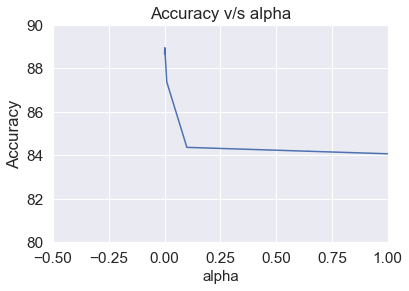

In [55]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  88.63270237615787
Precision  0.8870328707667191
Recall  0.988123357397119
F1-Score  0.934853198063274


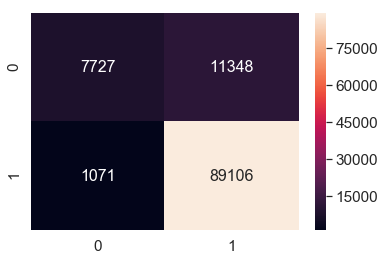

In [56]:
## Accuracy of BernouliNB using BiGram

bNB = BernoulliNB(gsv.best_params_['alpha']) ## alpha =  0.001
bNB.fit(X_train, y_train)

y_pred = bNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [57]:
%%time

### Multinomial NB 


mNB = MultinomialNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "MNB_gsv_bi")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.1min finished


Best Param =  {'alpha': 0.001}
Best Accuracy =  89.78251488737378
Wall time: 2min 5s


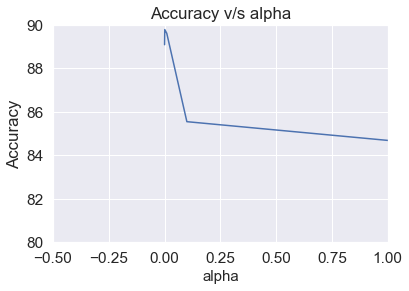

In [58]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  88.68029875883279
Precision  0.8839814449269641
Recall  0.993213347084068
F1-Score  0.9354193538279973


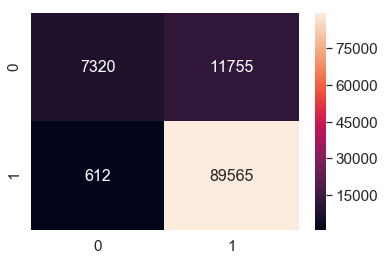

In [59]:
## Accuracy for MultinomialNB using BiGram 

mNB = MultinomialNB(gsv.best_params_['alpha']) ## alpha =  0.001
mNB.fit(X_train, y_train)

y_pred = mNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [60]:
### Feature Importance 
get_important_features(bi_gram, bNB)

			Positive						Negative
-19.194873215584956  ::  aa preservativeoh  	::		  -1.152660293245365  ::  not
-19.194873215584956  ::  aaa dont  	::		  -1.194339823305036  ::  like
-19.194873215584956  ::  aaaaaaarrrrrggghhh  	::		  -1.2247856916660727  ::  tast
-19.194873215584956  ::  aaaaaaarrrrrggghhh back  	::		  -1.2779928139118368  ::  love
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa  	::		  -1.2964161234932288  ::  good
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa fire  	::		  -1.315494467979061  ::  great
-19.194873215584956  ::  aachen  	::		  -1.4490675877672086  ::  flavor
-19.194873215584956  ::  aachen munich  	::		  -1.488869750307627  ::  one
-19.194873215584956  ::  aachen printen  	::		  -1.4971186580771203  ::  use
-19.194873215584956  ::  aafco brewer  	::		  -1.550199636331893  ::  tri


In [61]:
get_important_features(bi_gram, mNB)

			Positive						Negative
-21.177901844267616  ::  aa preservativeoh  	::		  -5.085999915798032  ::  not
-21.177901844267616  ::  aaa dont  	::		  -5.106529994694398  ::  like
-21.177901844267616  ::  aaaaaaarrrrrggghhh  	::		  -5.1237481970079966  ::  tast
-21.177901844267616  ::  aaaaaaarrrrrggghhh back  	::		  -5.1326979169379925  ::  love
-21.177901844267616  ::  aaaaaahhhhhyaaaaaa  	::		  -5.163419319892512  ::  great
-21.177901844267616  ::  aaaaaahhhhhyaaaaaa fire  	::		  -5.193983408649325  ::  good
-21.177901844267616  ::  aachen  	::		  -5.315643550811039  ::  flavor
-21.177901844267616  ::  aachen munich  	::		  -5.408244490805792  ::  use
-21.177901844267616  ::  aachen printen  	::		  -5.438083596760787  ::  product
-21.177901844267616  ::  aafco brewer  	::		  -5.493672338611383  ::  one


In [63]:
%%time
######################################################## 

# TF-IDF - uni_gram - BernoulliNB

from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample.Score.values,
                                                   test_size=0.3,
                                                   shuffle=False)

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)

X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Train ", X_train.shape)
print ("Test", X_test.shape)

Train  (254919, 161941)
Test (109252, 161941)
Wall time: 27.4 s


In [64]:
%%time

### Bernoulli NB 


bNB = BernoulliNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(bNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "BNB_gsv_tfidf")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   42.4s finished


Best Param =  {'alpha': 0.001}
Best Accuracy =  87.4480020712868
Wall time: 43 s


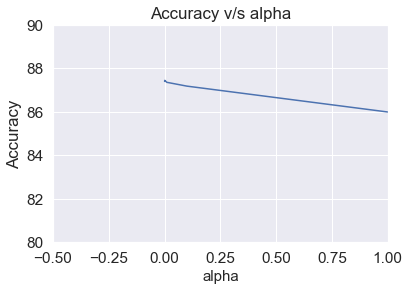

In [65]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  88.07893677003624
Precision  0.9185409410973321
Recall  0.9388314093394102
F1-Score  0.9285753457712261


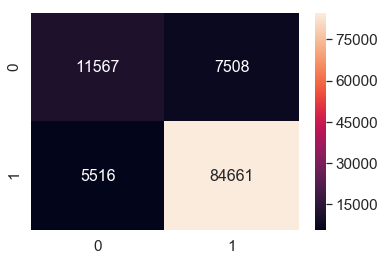

In [66]:
### Accuracy for TfIdf - uni_gram - BernoulliNB 

bNB = BernoulliNB(gsv.best_params_['alpha']) ## alpha =  0.001
bNB.fit(X_train, y_train)

y_pred = bNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [67]:
%%time
####### TfIdf MultinomialNB uni_gram 

mNB = MultinomialNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "MNB_gsv_tfidf_uni")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Param =  {'alpha': 0.01}
Best Accuracy =  87.09717787175283
Wall time: 26 s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   25.7s finished


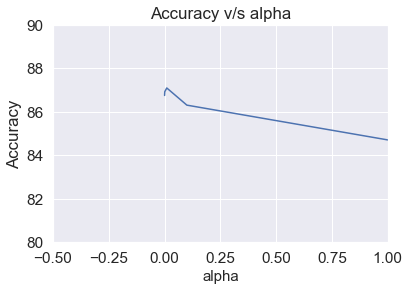

In [68]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  86.15128327170211
Precision  0.8619618586435414
Recall  0.9909067722368231
F1-Score  0.9219475454489178


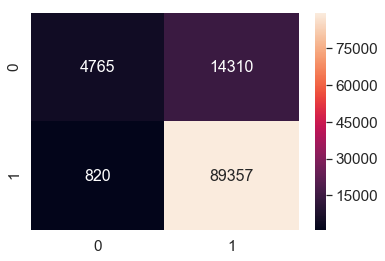

In [69]:
## Accuracy for TfIdf - MultinomialNB - uni_gram 

mNB = MultinomialNB(gsv.best_params_['alpha']) ## alpha =  0.001
mNB.fit(X_train, y_train)

y_pred = mNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [70]:
#### get important Features 

# TfIdf BernoulliNB uni_gram 
get_important_features(tfidf, bNB)

			Positive						Negative
-19.194873215584956  ::  aaaaaaarrrrrggghhh  	::		  -1.152660293245365  ::  not
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa  	::		  -1.194339823305036  ::  like
-19.194873215584956  ::  aachen  	::		  -1.2247856916660727  ::  tast
-19.194873215584956  ::  aalso  	::		  -1.2779928139118368  ::  love
-19.194873215584956  ::  aamzonhowev  	::		  -1.2964161234932288  ::  good
-19.194873215584956  ::  aauc  	::		  -1.315494467979061  ::  great
-19.194873215584956  ::  abad  	::		  -1.4490675877672086  ::  flavor
-19.194873215584956  ::  abalon  	::		  -1.488869750307627  ::  one
-19.194873215584956  ::  abandonedterr  	::		  -1.4971186580771203  ::  use
-19.194873215584956  ::  abbazabba  	::		  -1.550199636331893  ::  tri


In [71]:
# TfIdf MultinomialNB uni_gram
get_important_features(tfidf, mNB)

			Positive						Negative
-18.435830267669566  ::  aaaaaaarrrrrggghhh  	::		  -5.106458700617482  ::  great
-18.435830267669566  ::  aaaaaahhhhhyaaaaaa  	::		  -5.110431590701733  ::  love
-18.435830267669566  ::  aachen  	::		  -5.1821295940952155  ::  tast
-18.435830267669566  ::  aalso  	::		  -5.184852341893738  ::  good
-18.435830267669566  ::  aamzonhowev  	::		  -5.190368338590158  ::  like
-18.435830267669566  ::  aauc  	::		  -5.215690425796531  ::  tea
-18.435830267669566  ::  abad  	::		  -5.236091126875351  ::  not
-18.435830267669566  ::  abalon  	::		  -5.2572381143324804  ::  flavor
-18.435830267669566  ::  abandonedterr  	::		  -5.291373820842232  ::  coffe
-18.435830267669566  ::  abbazabba  	::		  -5.359733604888765  ::  product


In [73]:
#### TFIDF - BiGram - BernoulliNB

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample.Score.values,
                                                   test_size=0.3,
                                                   shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1, 2))
X_train = tfidf.fit_transform(X_train)

X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Train ", X_train.shape)
print ("Test", X_test.shape)

Train  (254919, 2642089)
Test (109252, 2642089)


In [74]:
%%time

### Bernoulli NB 


bNB = BernoulliNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(bNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "BNB_gsv_tfidf_bigram")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.6min finished


Best Param =  {'alpha': 0.001}
Best Accuracy =  88.9470958833175
Wall time: 2min 40s


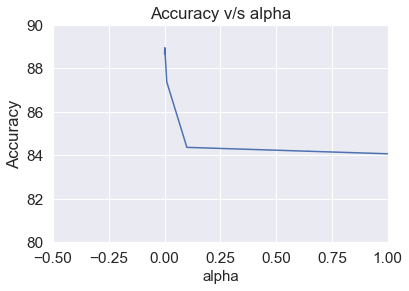

In [75]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  88.63270237615787
Precision  0.8870328707667191
Recall  0.988123357397119
F1-Score  0.934853198063274


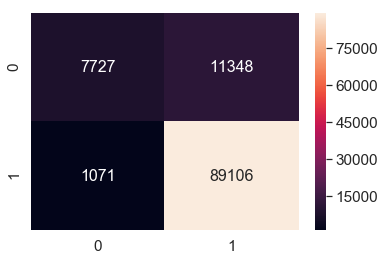

In [76]:
## Accuracy TfIdf BernoulliNB bigram 

bNB = BernoulliNB(gsv.best_params_['alpha']) ## alpha =  0.001
bNB.fit(X_train, y_train)

y_pred = bNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [77]:
%%time

### TfIdf - MultinomialNB , Bigram 


### MultinomialNB NB 


mNB = MultinomialNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "MNB_gsv_tfidf_bigram")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.8min finished


Best Param =  {'alpha': 0.0001}
Best Accuracy =  88.01760593768878
Wall time: 1min 46s


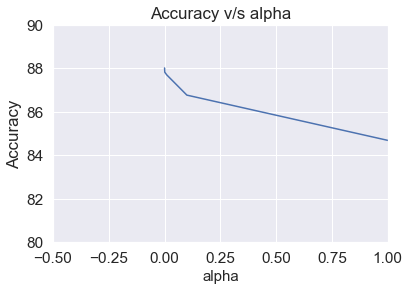

In [78]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  86.67667411122908
Precision  0.8664198703350163
Recall  0.9914390587400335
F1-Score  0.924723064034008


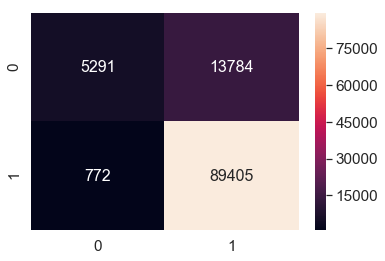

In [79]:
## Accuracy TfIdf MultinomialNBnomialNBnomialNBMultinomialNBlNB Bigram 
mNB = MultinomialNB(gsv.best_params_['alpha']) ## alpha =  0.001
mNB.fit(X_train, y_train)

y_pred = mNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [80]:
## Feature importance 

# TfIdf BernoulliNB bigram 
get_important_features(tfidf, bNB)

			Positive						Negative
-19.194873215584956  ::  aa preservativeoh  	::		  -1.152660293245365  ::  not
-19.194873215584956  ::  aaa dont  	::		  -1.194339823305036  ::  like
-19.194873215584956  ::  aaaaaaarrrrrggghhh  	::		  -1.2247856916660727  ::  tast
-19.194873215584956  ::  aaaaaaarrrrrggghhh back  	::		  -1.2779928139118368  ::  love
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa  	::		  -1.2964161234932288  ::  good
-19.194873215584956  ::  aaaaaahhhhhyaaaaaa fire  	::		  -1.315494467979061  ::  great
-19.194873215584956  ::  aachen  	::		  -1.4490675877672086  ::  flavor
-19.194873215584956  ::  aachen munich  	::		  -1.488869750307627  ::  one
-19.194873215584956  ::  aachen printen  	::		  -1.4971186580771203  ::  use
-19.194873215584956  ::  aafco brewer  	::		  -1.550199636331893  ::  tri


In [81]:
# TfIdf MultinomialNB bigram
get_important_features(tfidf, mNB)

			Positive						Negative
-23.443497383535192  ::  aa preservativeoh  	::		  -6.246543099370942  ::  love
-23.443497383535192  ::  aaa dont  	::		  -6.247672540080973  ::  great
-23.443497383535192  ::  aaaaaaarrrrrggghhh  	::		  -6.302917694223479  ::  like
-23.443497383535192  ::  aaaaaaarrrrrggghhh back  	::		  -6.303542588793581  ::  tast
-23.443497383535192  ::  aaaaaahhhhhyaaaaaa  	::		  -6.310544479315506  ::  tea
-23.443497383535192  ::  aaaaaahhhhhyaaaaaa fire  	::		  -6.316488641665398  ::  good
-23.443497383535192  ::  aachen  	::		  -6.345824815420337  ::  not
-23.443497383535192  ::  aachen munich  	::		  -6.377102550505412  ::  flavor
-23.443497383535192  ::  aachen printen  	::		  -6.405988472154915  ::  coffe
-23.443497383535192  ::  aafco brewer  	::		  -6.469829884929544  ::  use


In [82]:
### Lets Try for different gram 

# TfIdf MultinomialNB tri-gram 


X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample.Score.values,
                                                   test_size=0.3,
                                                   shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train = tfidf.fit_transform(X_train)

X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Train ", X_train.shape)
print ("Test", X_test.shape)

Train  (254919, 9814784)
Test (109252, 9814784)


In [83]:
%%time 

## MultinomialNB Tri-gram 

mNB = MultinomialNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "MNB_gsv_tfidf_trigram")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.0min finished


Best Param =  {'alpha': 0.1}
Best Accuracy =  86.48226460688703
Wall time: 4min 7s


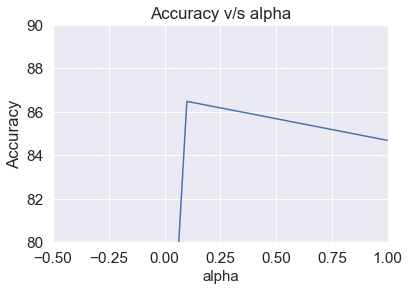

In [84]:
x =[]
y = []

for i in gsv.grid_scores_:
    x.append(i[0]['alpha'])
    y.append(i[1]  * 100)

plt.xlim(-0.5,1)
plt.ylim(80,90)
plt.xlabel("alpha",fontsize=15)
plt.ylabel("Accuracy")
plt.title('Accuracy v/s alpha')
plt.plot(x,y)
plt.show()

Accuracy =  83.68450920806941
Precision  0.8350436216126105
Recall  0.999844749769897
F1-Score  0.9100433507779422


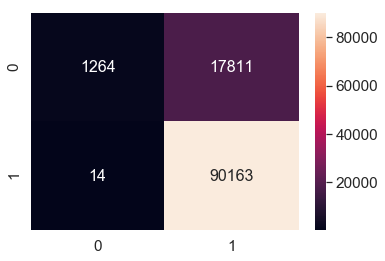

In [85]:
## Accuracy MultinMultinomialNBNB MultinomialNB Tri-gram

mNB = MultinomialNB(gsv.best_params_['alpha']) ## alpha =  0.001
mNB.fit(X_train, y_train)

y_pred = mNB.predict(X_test)

print ("Accuracy = ", (accuracy_score(y_test, y_pred) * 100))
print("Precision ", (precision_score(y_test, y_pred)))
print("Recall ", (recall_score(y_test, y_pred)))
print("F1-Score ", (f1_score(y_test, y_pred)))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2), range(2))

sns.set(font_scale=1.4)

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

In [87]:
### Feature Importance
get_important_features(tfidf, mNB)

			Positive						Negative
-17.179120915981468  ::  aa preservativeoh  	::		  -7.257540309424325  ::  love
-17.179120915981468  ::  aa preservativeoh thank  	::		  -7.262122311926656  ::  great
-17.179120915981468  ::  aaa dont  	::		  -7.3091101972447925  ::  like
-17.179120915981468  ::  aaa dont think  	::		  -7.313444796373888  ::  tast
-17.179120915981468  ::  aaaaaaarrrrrggghhh  	::		  -7.316649475500946  ::  tea
-17.179120915981468  ::  aaaaaaarrrrrggghhh back  	::		  -7.327554436738941  ::  good
-17.179120915981468  ::  aaaaaaarrrrrggghhh back dark  	::		  -7.349218909033351  ::  not
-17.179120915981468  ::  aaaaaahhhhhyaaaaaa  	::		  -7.386659159272174  ::  flavor
-17.179120915981468  ::  aaaaaahhhhhyaaaaaa fire  	::		  -7.419989560570672  ::  coffe
-17.179120915981468  ::  aaaaaahhhhhyaaaaaa fire weapon  	::		  -7.469599210779484  ::  use


In [ ]:
%%time
########### TfIdf MultinomialNB 5-Gram 

X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,
                                                   df_sample.Score.values,
                                                   test_size=0.2,
                                                   shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(4, 5))
X_train = tfidf.fit_transform(X_train)

X_train = preprocessing.normalize(X_train)

X_test = tfidf.transform(X_test)
X_test = preprocessing.normalize(X_test)

print ("Train ", X_train.shape)
print ("Test", X_test.shape)


In [ ]:
%%time 

## MultinomialNB Tri-gram 

mNB = MultinomialNB()
param_grid = {'alpha':[10, 1, 0.1, 0.01, 0.001, 0.0001]}

tscv = TimeSeriesSplit(n_splits=10)

gsv = GridSearchCV(mNB, param_grid, cv=tscv, verbose=1)

gsv.fit(X_train, y_train)

savetofile(gsv, "MNB_gsv_tfidf_5gram")

print ("Best Param = ", gsv.best_params_)
print ("Best Accuracy = ", gsv.best_score_ * 100)